# 10장 MNIST를 활용한 숫자 인식

* "부록3 매트플롯립 입문"에서 한글 폰트를 올바르게 출력하기 위한 설치 방법을 설명했다. 설치 방법은 다음과 같다.

In [ ]:
# 한글 폰트 설치

!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

In [ ]:
# 필요 라이브러리 설치

!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

* 모든 설치가 끝나면 한글 폰트를 바르게 출력하기 위해 **[런타임]** -> **[런타임 다시시작]**을 클릭한 다음, 아래 셀부터 코드를 실행해 주십시오.

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window 
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [46]:
# 파이토치 관련 라이브러리
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchviz import make_dot
from torchinfo import summary
from tqdm.notebook import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
# 기본 폰트 설정
# 윈도우에서는 "malgun.ttf" 혹은 "NanumBarunGothic.ttf" 등을 사용할 수 있다. 맥에서는 "AppleGothic.ttf"
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'


# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

## MNIST 숫자 인식

### 활성화 함수와 ReLU 함수

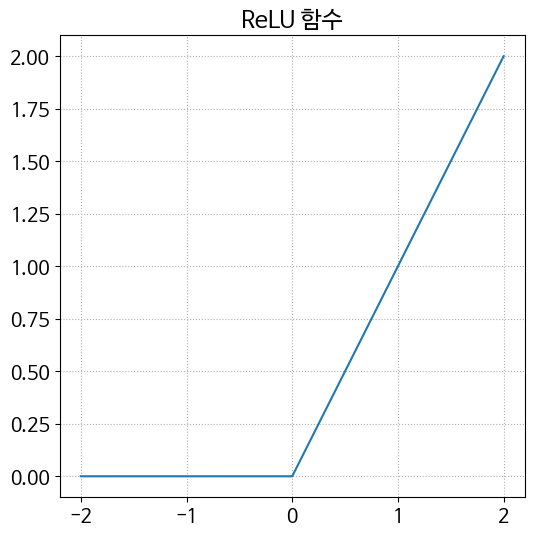

In [5]:
# ReLU 함수의 그래프

relu = nn.ReLU()
x_np = np.arange(-2, 2.1, 0.25)
x = torch.tensor(x_np).float()
y = relu(x)

plt.plot(x.data, y.data)
plt.title('ReLU 함수')
plt.show()

### GPU 디바이스 확인

In [4]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
# 텐서 변수 x, y 
x_np = np.arange(-2.0, 2.1, 0.25)
y_np = np.arange(-1.0, 3.1, 0.25)
x = torch.tensor(x_np).float()
y = torch.tensor(y_np).float()

# x와 y 사이의 연산
z = x * y
print(z)

tensor([ 2.0000,  1.3125,  0.7500,  0.3125, -0.0000, -0.1875, -0.2500, -0.1875,
         0.0000,  0.3125,  0.7500,  1.3125,  2.0000,  2.8125,  3.7500,  4.8125,
         6.0000])


In [8]:
# 변수 x를 GPU로 보냄
x = x.to(device)

# 변수 x와 y의 디바이스 속성 확인
print('x: ', x.device)
print('y: ', y.device)

x:  cuda:0
y:  cpu


In [9]:
# 이 상태에서 x와 y의 연산을 수행하면...

z = x * y

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [5]:
# y도 GPU로 보냄
y = y.to(device)

# 연산이 가능해짐
z = x * y
print(z)
print("z.device = ", z.device)

NameError: name 'y' is not defined

### MNIST Dataset을 활용해 불러오기

In [7]:
# 라이브러리 임포트
import torchvision.datasets as datasets

# 다운로드받을 디렉터리명
data_root = './data'

train_set0 = datasets.MNIST(
    # 원본 데이터를 다운로드받을 디렉터리 지정
    root = data_root,  
    # 훈련 데이터인지 또는 검증 데이터인지
    train = True,  
    # 원본 데이터가 없는 경우, 다운로드를 실행하는지 여부
    download = True)

In [ ]:
# 다운로드한 파일 확인 
# 리눅스 명령어
!ls -lR ./data/MNIST

# Window 명령어
# !dir /s data\MNIST

In [25]:
# 데이터 건수 확인
print("train_set0 타입:", type(train_set0))
print("train_set0 : \n", train_set0)
print('데이터 건수: ', len(train_set0))


# 첫번째 요소 가져오기
image, label = train_set0[0]

# 데이터 타입 확인
print("="*50)
print('입력 데이터 타입 : ', type(image)) # <class 'PIL.Image.Image'>
print('정답 데이터 타입 : ', type(label)) # <class 'int'>

print("max = ", np.array(image).max())
print("min = ", np.array(image).min())


train_set0 타입: <class 'torchvision.datasets.mnist.MNIST'>
train_set0 : 
 Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
데이터 건수:  60000
입력 데이터 타입 :  <class 'PIL.Image.Image'>
정답 데이터 타입 :  <class 'int'>
max =  255
min =  0


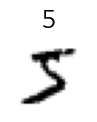

In [26]:
# 입력 데이터를 이미지로 출력

plt.figure(figsize=(1,1))
plt.title(f'{label}')
plt.imshow(image, cmap='gray_r')
plt.axis('off')
plt.show()

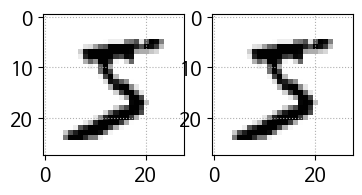

In [27]:
## plt.subplot

plt.figure(figsize=(4, 2))
plt.subplot(1,2,1), plt.imshow(image, cmap = 'gray_r')
plt.subplot(1,2,2), plt.imshow(image, cmap = 'gray_r')
plt.show()


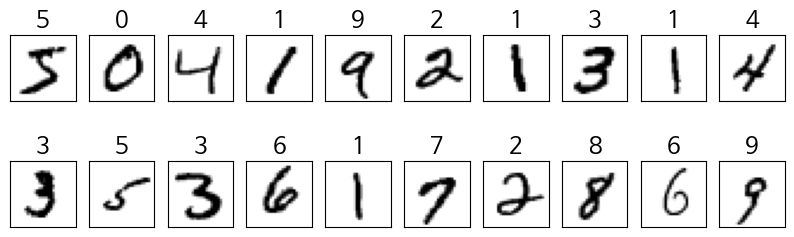

In [28]:
# 정답 데이터와 함께 처음 20개 데이터를 이미지로 출력

plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # image와 label 취득
    image, label = train_set0[i]
    
    # 이미지 출력
    plt.imshow(image, cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Transforms를 활용한 데이터 전처리

In [29]:
# 라이브러리 임포트
# import torchvision.transforms as transforms

transform1 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root,  
    train=True,  
    download=True,
    transform = transform1)

In [30]:
# 변환 결과 확인

image, label = train_set1[0]
print('입력 데이터 타입 : ', type(image)) # <class 'torch.Tensor'>
print('입력 데이터 shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

입력 데이터 타입 :  <class 'torch.Tensor'>
입력 데이터 shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(0.)
최댓값 :  tensor(1.)


### Normalize 사용 하기

In [32]:
## 순서 중요
transform2 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),
    
    # 데이터 정규화
    transforms.Normalize(mean = 0.5,  std = 0.5), # z-transform
])

train_set2 = datasets.MNIST(
    root = data_root,  
    train = True,  
    download = True,
    transform = transform2)

In [33]:
# 변환 결과 확인

image, label = train_set2[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([1, 28, 28])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


### 람다 표현식을 활용한 함수 정의

In [ ]:
def f(x):
    return 1/np.exp(-10*x)


lambda x: 1/np.exp(-10*x)

In [ ]:
# 일반적인 함수의 정의

def f(x):
    return (2 * x**2 + 2)

x = np.arange(-2, 2.1, 0.25)
y = f(x)
print(y)


# 람다 표현식으로 함수 정의
print("="*50)
g = lambda x: 2 * x**2 + 2

y = g(x)
print(y)

### Lambda 클래스를 사용해 1차원으로 텐서 변환하기

In [ ]:
transform = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),
    
    # 데이터 정규화
    transforms.Normalize(0.5, 0.5),

    # 현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1))
    
])

train_set = datasets.MNIST(
    root = data_root,  
    train = True,  
    download=True, 
    transform = transform)

In [8]:
transform3 = transforms.Compose([
    # 데이터를 텐서로 변환
    transforms.ToTensor(),
    
    # 데이터 정규화
    transforms.Normalize(0.5, 0.5),
    
    # 현재 텐서를 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root,  
    train = True,  
    download=True, 
    transform = transform3)

In [35]:
# 변환 결과 확인

image, label = train_set3[0]
print('shape : ', image.shape)
print('최솟값 : ', image.data.min())
print('최댓값 : ', image.data.max())

shape :  torch.Size([784])
최솟값 :  tensor(-1.)
최댓값 :  tensor(1.)


### 최종 구현 형태

In [12]:
# 데이터 변환용 함수 Transforms
# (1) Image를 텐서화
# (2) [0, 1] 범위의 값을 [-1, 1] 범위로 조정
# (3) 데이터의 shape을 [1, 28, 28] 에서 [784] 로 변환

transform = transforms.Compose([
    # (1) 데이터를 텐서로 변환
    transforms.ToTensor(),
    
    # (2) 데이터 정규화
    transforms.Normalize(0.5, 0.5),
    
    # (3) 1계 텐서로 변환
    transforms.Lambda(lambda x: x.view(-1)),
])

In [13]:
# 데이터 입수를 위한 Dataset 함수

# 훈련용 데이터셋 정의
train_set = datasets.MNIST(
    root = data_root, 
    train = True,
    download = True, 
    transform = transform)

# 검증용 데이터셋 정의
test_set = datasets.MNIST(
    root = data_root, 
    train = False, 
    download = True, 
    transform = transform)

### 데이터로더를 활용한 미니 배치 데이터 생성

In [14]:
# 라이브러리 임포트
from torch.utils.data import DataLoader

# 미니 배치 사이즈 지정
batch_size = 500

# 훈련용 데이터로더
# 훈련용이므로, 셔플을 적용함
train_loader = DataLoader(
    dataset = train_set, 
    batch_size = batch_size, 
    shuffle = True)

# 검증용 데이터로더
# 검증시에는 셔플을 필요로하지 않음
test_loader = DataLoader(
    dataset = test_set,  
    batch_size = batch_size, 
    shuffle = False)

In [17]:
# 몇 개의 그룹으로 데이터를 가져올 수 있는가
# images, labels = next(iter(train_loader))

print(len(train_loader))

# 데이터로더로부터 가장 처음 한 세트를 가져옴
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

# print("max value = ", images.max())

120
torch.Size([500, 784])
torch.Size([500])


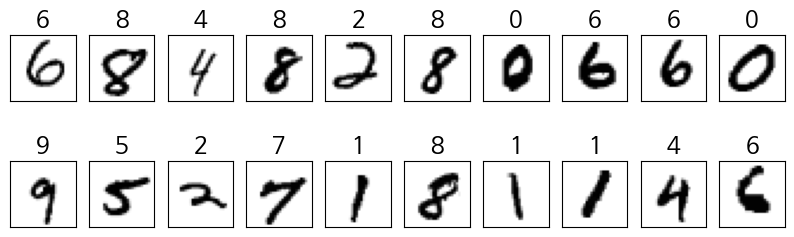

In [18]:
# 이미지 출력
plt.figure(figsize=(10, 3))
# fig, axs = plt.subplots(2, 10, figsize = (10, 3))

for i in range(20):
    ax = plt.subplot(2, 10, i + 1)

    # row = i//10
    # col = i % 10
    
    # 넘파이로 배열로 변환
    image = images[i].numpy()
    label = labels[i]
    
    # 이미지의 범위를 [0, 1] 로 되돌림
    image2 = (image + 1)/ 2

    # 이미지 출력
    plt.imshow(image2.reshape(28, 28), cmap='gray_r')
    # ax.set_title(str(label.item()))
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # axs[row, col].imshow(image2.reshape(28, 28), cmap='gray_r')
    # axs[row, col].set_title(f'{label}')
    # axs[row, col].get_xaxis().set_visible(False)
    # axs[row, col].get_yaxis().set_visible(False)
plt.show()

### 모델 정의

In [19]:
# 입력 차원수
n_input = image.shape[0]

# 출력 차원수
# 분류 클래스 수는 10
n_output = len(set(list(labels.data.numpy())))

# 은닉층의 노드 수
n_hidden = 128

# 결과 확인
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 128 n_output: 10


In [42]:
# 모델 정의
# 784입력 10출력 1은닉층의 신경망 모델

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 은닉층 정의(은닉층 노드 수 : n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 출력층 정의
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [122]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

# 모델 인스턴스 생성
net = Net(n_input, n_output, n_hidden)

# 모델을 GPU로 전송
net = net.to(device)
# next(net.parameters()).is_cuda

In [123]:
# 학습률
lr = 0.01

# 최적화 알고리즘: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

In [124]:
# 모델 내부 파라미터 확인
# l1.weight, l1.bias, l2.weight, l2.bias를 확인할 수 있음

for parameter in net.named_parameters():
    print(parameter)

# list(net.named_parameters())[0][1].data.cpu().numpy()

('l1.weight', Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0277,  0.0200,  0.0315],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0089, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0328, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([ 0.0325, -0.0298,  0.0013,  0.0199,  0.0268, -0.0248, -0.0172, -0.0355,
         0.0122, -0.0048,  0.0214,  0.0202, -0.0243,  0.0015, -0.0276,  0.0296,
         0.0341, -0.0228,  0.0230,  0.0347, -0.0091, -0.0346,  0.0206, -0.0060,
         0.0329,  0.0047,  0.0180,  0.0101,  0.0177, -0.0309,  0.0228, -0.0224,
         0.0321,  0.0179,  0.0321,  0.0184,  0.0219, -0.0089,  0.0310, -0.0039,
        -0.0074, -0.0317,  0.0192, -0.0021,  0.0190

In [125]:
# 모델 개요 표시 1

print(net)

Net(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [126]:
# 모델 개요 표시 2

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [10]                      1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (M): 12.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

### 경사 하강법

In [89]:
# 훈련 데이터셋의 가장 처음 항목을 취득
# 데이터로더에서 가장 처음 항목을 취득
for images, labels in train_loader:
    break 

In [90]:
# 데이터로더에서 취득한 데이터를 GPU로 보냄
inputs = images.to(device)
labels = labels.to(device)

In [91]:
# 예측 계산
outputs = net(inputs)

# 결과 확인
print(outputs)


tensor([[-0.2889, -0.1390,  0.2119,  ...,  0.1322,  0.1662,  0.0407],
        [-0.4326, -0.4011, -0.0427,  ..., -0.0614, -0.0913, -0.0299],
        [-0.2970, -0.1195,  0.3091,  ...,  0.1917,  0.2213,  0.0720],
        ...,
        [-0.3772, -0.1952, -0.0905,  ...,  0.1855, -0.0120,  0.1994],
        [-0.2699, -0.1496,  0.0944,  ...,  0.1439,  0.0321,  0.0870],
        [-0.4083, -0.1225,  0.2121,  ...,  0.2090,  0.1628,  0.1156]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)


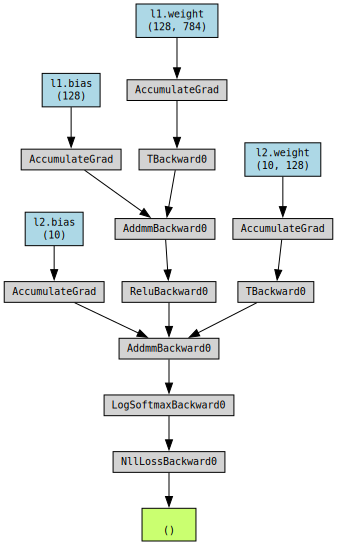

In [92]:
#  손실 계산
loss = criterion(outputs, labels)

# 손실값 가져오기
print(loss)

# 손실 계산 그래프 시각화
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

### 경사 계산

In [127]:
next(net.parameters()).is_cuda

True

In [96]:
# 경사 계산 실행
loss.backward()

In [97]:
# 경사 계산 결과
w = net.to('cpu')
print(w.l1.weight.grad.numpy())
print(w.l1.bias.grad.numpy())
print(w.l2.weight.grad.numpy())
print(w.l2.bias.grad.numpy())

[[-0.001  -0.001  -0.001  ... -0.001  -0.001  -0.001 ]
 [ 0.003   0.003   0.003  ...  0.003   0.003   0.003 ]
 [-0.0033 -0.0033 -0.0033 ... -0.0033 -0.0033 -0.0033]
 ...
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 [ 0.002   0.002   0.002  ...  0.002   0.002   0.002 ]
 [-0.0002 -0.0002 -0.0002 ... -0.0002 -0.0002 -0.0002]]
[ 0.001  -0.003   0.0033 -0.0005  0.0003 -0.0005  0.0011 -0.0014 -0.0016
  0.0008  0.0006 -0.0025  0.0014  0.0022 -0.0018 -0.0002  0.0054 -0.002
 -0.0003  0.0052  0.0034  0.0043 -0.0019  0.0065 -0.0007 -0.0046  0.0039
  0.     -0.0017 -0.0053  0.0002  0.0026  0.0031 -0.0002  0.0012  0.0001
  0.0049 -0.0012  0.0036  0.0009  0.0022 -0.0048  0.0027  0.0088 -0.0025
 -0.0008 -0.0004 -0.0024 -0.0026 -0.0002 -0.0024  0.0009 -0.0017 -0.0002
 -0.0009 -0.0016 -0.0007 -0.0036 -0.0001  0.0033  0.0007 -0.0067  0.0032
  0.0019  0.     -0.0009  0.0025 -0.0015 -0.0047  0.0007 -0.0033 -0.0002
  0.0014 -0.0007 -0.006  -0.0025  0.0007 -0.0033  0.0001  0.0005  0.0009
  0.0013

### 파라미터 수정

In [98]:
# 경사 하강법 적용
optimizer.step()

In [99]:
# 파라미터 값 출력
print(net.l1.weight)
print(net.l1.bias)

Parameter containing:
tensor([[-0.0146,  0.0012, -0.0177,  ...,  0.0278,  0.0200,  0.0316],
        [ 0.0184, -0.0322,  0.0175,  ...,  0.0088, -0.0028, -0.0033],
        [ 0.0092,  0.0261,  0.0075,  ...,  0.0061,  0.0267, -0.0258],
        ...,
        [ 0.0235, -0.0026, -0.0129,  ...,  0.0322, -0.0059, -0.0169],
        [-0.0329, -0.0258,  0.0124,  ..., -0.0049,  0.0006,  0.0334],
        [ 0.0187, -0.0076, -0.0202,  ...,  0.0325, -0.0159, -0.0240]],
       requires_grad=True)
Parameter containing:
tensor([ 3.2472e-02, -2.9729e-02,  1.2587e-03,  1.9887e-02,  2.6832e-02,
        -2.4753e-02, -1.7199e-02, -3.5512e-02,  1.2241e-02, -4.7697e-03,
         2.1381e-02,  2.0192e-02, -2.4305e-02,  1.4961e-03, -2.7621e-02,
         2.9627e-02,  3.4058e-02, -2.2768e-02,  2.2968e-02,  3.4607e-02,
        -9.1578e-03, -3.4637e-02,  2.0582e-02, -6.0717e-03,  3.2938e-02,
         4.7869e-03,  1.7944e-02,  1.0102e-02,  1.7692e-02, -3.0832e-02,
         2.2809e-02, -2.2382e-02,  3.2036e-02,  1.7892e-0

### 반복 계산

In [ ]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)


# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
# num_epochs = 100
num_epochs = 10


# 평가 결과 기록
history = np.zeros((0,5))

In [129]:
# tqdm 라이브러리 임포트
from tqdm.notebook import tqdm

# 반복 계산 메인 루프
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # 훈련 페이즈
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPU로 전송
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 경사 계산
        loss.backward()
    
        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 손실과 정확도 계산
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    # 예측 페이즈
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # 예측 계산
        outputs_test = net(inputs_test)

        # 손실 계산
        loss_test = criterion(outputs_test, labels_test)

        # 예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        # 손실과 정확도 계산
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 평가 결과 산출, 기록
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.45883 acc: 0.87878 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.39176 acc: 0.89063 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.37875 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


### 결과 확인

In [130]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기상태 : 손실 : 1.32629  정확도 : 0.74660
최종상태 : 손실 : 0.35741  정확도 : 0.89930


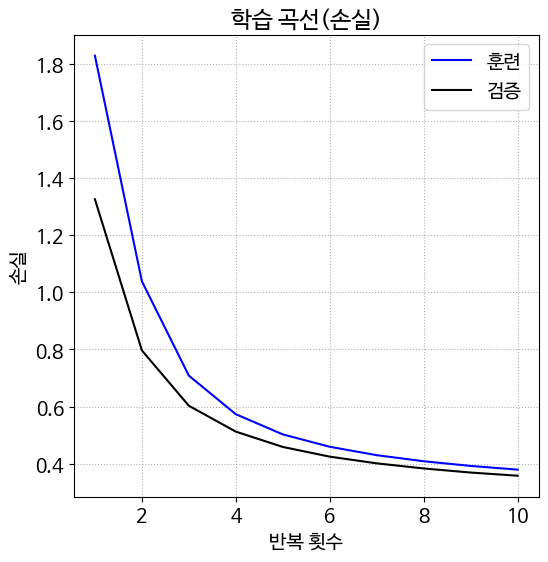

In [131]:
# 학습 곡선 출력(손실)

plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

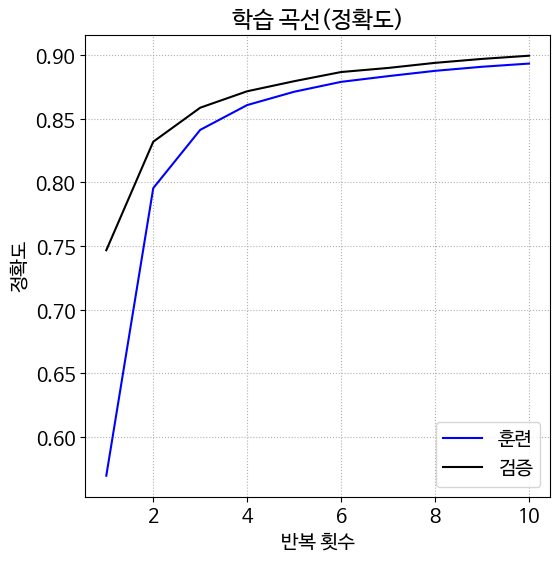

In [132]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 이미지 출력 확인

In [133]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

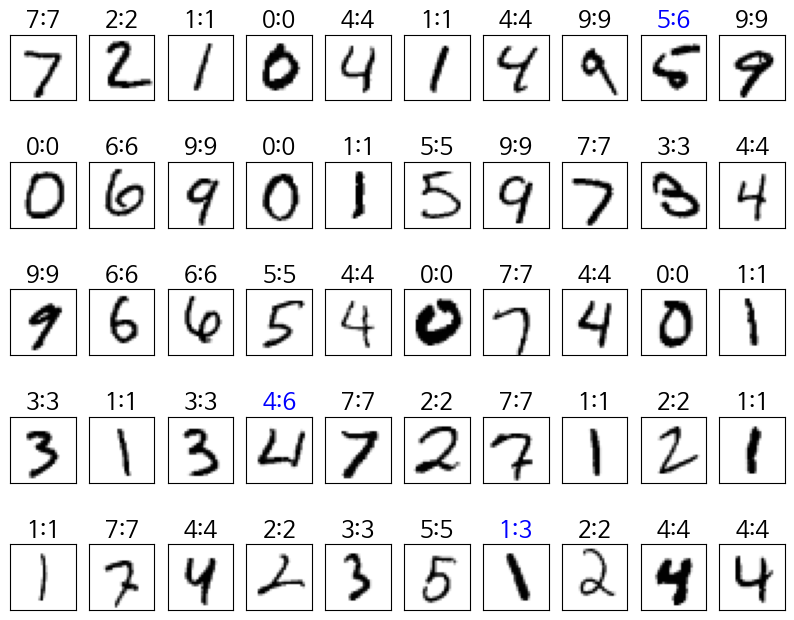

In [135]:
# 처음 50건의 이미지에 대해 "정답:예측"으로 출력

plt.figure(figsize=(10, 8))
for i in range(50):
  ax = plt.subplot(5, 10, i + 1)
    
  # 넘파이 배열로 변환
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c = 'k'
  else:
    c = 'b'
    
  # 이미지의 범위를 [0, 1] 로 되돌림
  image2 = (image + 1)/ 2
    
  # 이미지 출력
  plt.imshow(image2.reshape(28, 28),cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### 은닉층 추가하기

In [166]:
# 모델 정의
# 784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 첫번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 두번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 출력층 정의
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [167]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 모델 초기화
net = Net2(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [157]:
print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [158]:
# 모델 개요 표시 2

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [10]                      --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [128]                     16,512
├─ReLU: 1-4                              [128]                     --
├─Linear: 1-5                            [10]                      1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 14.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.48

In [168]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)

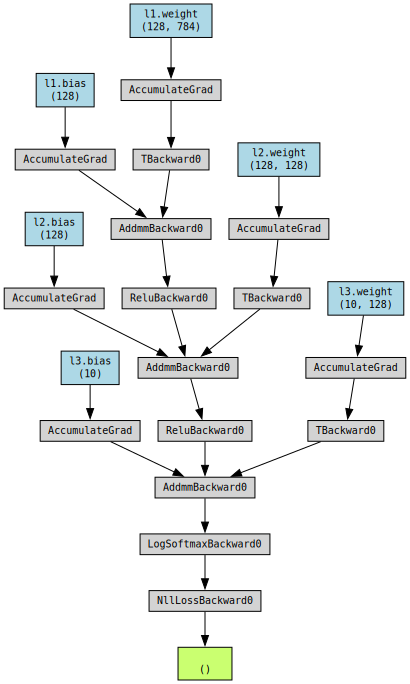

In [169]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
make_dot(loss, params=dict(net.named_parameters()))

### 경사 계산

In [170]:
# 경사 계산
loss.backward()

# 경사 계산 결과 일부
w = net.to('cpu').l1.weight.grad.numpy()
print("w = ", w)

# 각 요소의 절댓값 평균
print(np.abs(w).mean())

w =  [[-0.0007 -0.0007 -0.0007 ... -0.0007 -0.0007 -0.0007]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 [-0.0005 -0.0005 -0.0005 ... -0.0005 -0.0005 -0.0005]
 ...
 [ 0.0015  0.0015  0.0015 ...  0.0015  0.0015  0.0015]
 [ 0.0002  0.0002  0.0002 ...  0.0002  0.0002  0.0002]
 [ 0.0003  0.0003  0.0003 ...  0.0003  0.0003  0.0003]]
0.0008487979


### 반복 계산

In [171]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)


# 모델 초기화
net = Net2(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history2 = np.zeros((0,5))

In [172]:
# 반복 계산 메인 루프

for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 훈련 페이즈
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPU로 전송
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # 경사 초기화
        optimizer.zero_grad()

        # 예측 계산
        outputs = net(inputs)

        # 손실 계산
        loss = criterion(outputs, labels)

        # 경사 계산
        loss.backward()
    
        # 파라미터 수정
        optimizer.step()

        # 예측 라벨 산출
        predicted = torch.max(outputs, 1)[1]

        # 손실과 정확도 계산
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item()

    # 예측 페이즈
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 예측 계산
        outputs_test = net(inputs_test)

        # 손실 계산
        loss_test = criterion(outputs_test, labels_test)

        # 예측 라벨 산출
        predicted_test = torch.max(outputs_test, 1)[1]

        # 손실과 정확도 계산
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 평가 결과 산출, 기록
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/10], loss: 2.20163 acc: 0.25380 val_loss: 2.04576, val_acc: 0.49800


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.75820 acc: 0.60443 val_loss: 1.39272, val_acc: 0.68680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/10], loss: 1.11284 acc: 0.75645 val_loss: 0.86510, val_acc: 0.80810


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.75170 acc: 0.82300 val_loss: 0.63477, val_acc: 0.84380


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.59030 acc: 0.84983 val_loss: 0.52462, val_acc: 0.86360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.50672 acc: 0.86653 val_loss: 0.46400, val_acc: 0.87440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.45680 acc: 0.87540 val_loss: 0.42148, val_acc: 0.88560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.42335 acc: 0.88190 val_loss: 0.39550, val_acc: 0.89020


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.39965 acc: 0.88768 val_loss: 0.37600, val_acc: 0.89360


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.38195 acc: 0.89183 val_loss: 0.35886, val_acc: 0.89880


In [173]:
# 손실과 정확도 확인

print(f'초기상태 : 손실 : {history2[0,3]:.5f}  정확도 : {history2[0,4]:.5f}' )
print(f'최종상태 : 손실 : {history2[-1,3]:.5f}  정확도 : {history2[-1,4]:.5f}' )

초기상태 : 손실 : 2.04576  정확도 : 0.49800
최종상태 : 손실 : 0.35886  정확도 : 0.89880


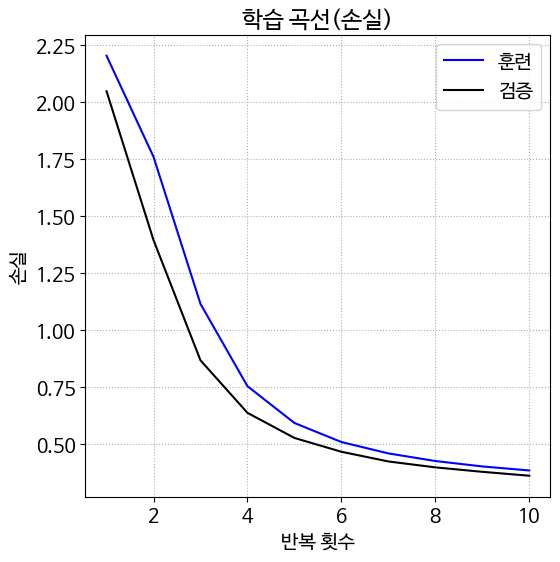

In [174]:
# 학습 곡선 출력(손실)
plt.plot(history2[:,0], history2[:,1], 'b', label='훈련')
plt.plot(history2[:,0], history2[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

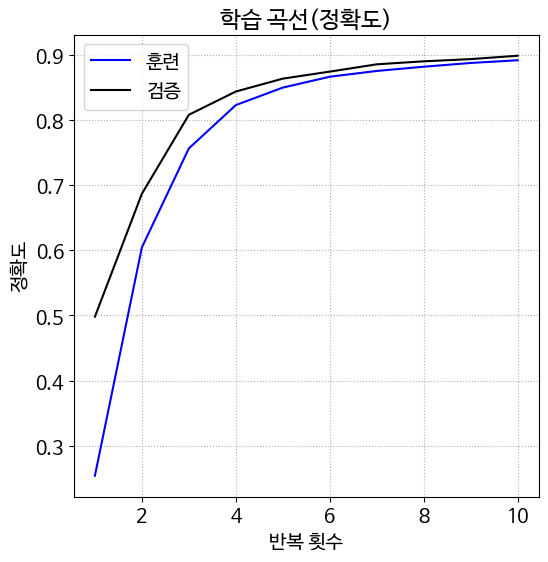

In [175]:
# 학습 곡선 출력(정확도)

plt.plot(history2[:,0], history2[:,2], 'b', label='훈련')
plt.plot(history2[:,0], history2[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

### 경사 소실과 ReLU 함수

In [20]:
# 모델 정의 -　시그모이드 함수 버전
# 784입력 10출력을 갖는 2개의 은닉층을 포함한 신경망

class Net3(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 첫번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 두번째 은닉층 정의(은닉층 노드 수: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 출력층 정의
        self.l3 = nn.Linear(n_hidden, n_output)

        # 시그모이드 함수 정의
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        x4 = self.sigmoid(x3)
        x5 = self.l3(x4)
        return x5

In [34]:
# 난수 고정
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 모델 초기화
net = Net3(n_input, n_output, n_hidden).to(device)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 최적화 함수: 경사 하강법
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [35]:
# 데이터로더에서 처음 한 세트 가져오기
for images, labels in test_loader:
    break

# 예측 결과 가져오기
inputs = images.to(device)
labels = labels.to(device)

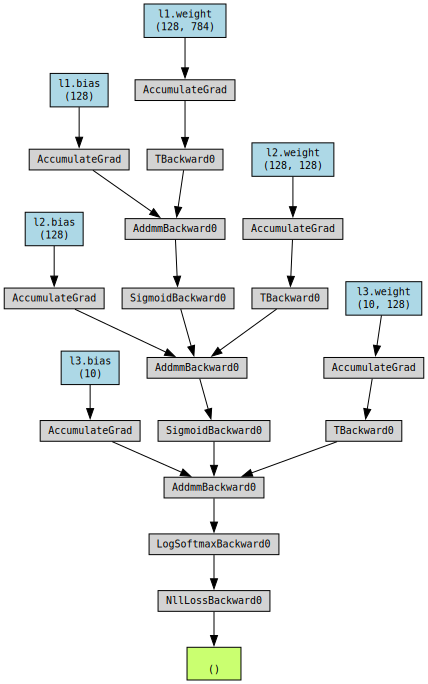

In [36]:
# 예측 계산
outputs = net(inputs)

# 손실 계산
loss = criterion(outputs, labels)

# 손실 계산 그래프 시각화
make_dot(loss, params=dict(net.named_parameters()))

In [37]:
# 경사 계산
loss.backward()

# 경사 계산 결과의 일부
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 각 요소의 절댓값 평균
print(np.abs(w).mean())

[[ 0.0001  0.0001  0.0001 ...  0.0001  0.0001  0.0001]
 [ 0.0001  0.0001  0.0001 ...  0.0001  0.0001  0.0001]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 ...
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]
 [ 0.0002  0.0002  0.0002 ...  0.0002  0.0002  0.0002]
 [-0.0001 -0.0001 -0.0001 ... -0.0001 -0.0001 -0.0001]]
0.00017514595


### 배치 사이즈와 정확도의 관계

In [80]:
# 학습용 함수
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):
    base_epochs = len(history)
    batch_size_train = len(train_loader)
    batch_size_test = len(test_loader)


    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        # 훈련 페이즈
        # count = 0

        for inputs, labels in tqdm(train_loader):
    
            # count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 경사 초기화
            optimizer.zero_grad()

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 경사 계산
            loss.backward()

            # 파라미터 수정
            optimizer.step()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            train_acc += (predicted == labels).sum().item() /len(labels)

            # 훈련 데이터에 대해 손실과 정확도 계산
        avg_train_loss = train_loss / batch_size_train
        avg_train_acc = train_acc / batch_size_train

        # 예측 페이즈
        # count = 0

        for inputs, labels in test_loader:
            # count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 예측 계산
            outputs = net(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 예측 라벨 산출
            predicted = torch.max(outputs, 1)[1]

            # 정답 건수 산출
            val_acc += (predicted == labels).sum().item() /len(labels)

            # 검증 데이터에 대해 손실과 정확도 계산
        avg_val_loss = val_loss / batch_size_test
        avg_val_acc = val_acc / batch_size_test
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

In [77]:
# 파이토치 난수 고정

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)

### Batch size  500

In [81]:
# 미니 배치 사이즈 지정
batch_size_train = 500

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, 
    batch_size = batch_size_train, 
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history = np.zeros((0,5))

In [82]:
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/10], loss: 1.82932 acc: 0.56960 val_loss: 1.32629, val_acc: 0.74660


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/10], loss: 1.03889 acc: 0.79537 val_loss: 0.79661, val_acc: 0.83180


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.70809 acc: 0.84110 val_loss: 0.60256, val_acc: 0.85850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.57300 acc: 0.86057 val_loss: 0.51192, val_acc: 0.87140


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.50223 acc: 0.87102 val_loss: 0.45827, val_acc: 0.87930


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.45883 acc: 0.87878 val_loss: 0.42422, val_acc: 0.88650


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.42938 acc: 0.88327 val_loss: 0.40076, val_acc: 0.88970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.40813 acc: 0.88743 val_loss: 0.38285, val_acc: 0.89370


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.39176 acc: 0.89063 val_loss: 0.36857, val_acc: 0.89680


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.37875 acc: 0.89313 val_loss: 0.35741, val_acc: 0.89930


### batch_size=200

In [50]:
# 미니 배치 사이즈 지정
batch_size_train = 200

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history3 = np.zeros((0,5))

In [51]:
history3 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history3)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.00650 acc: 0.71105 val_loss: 0.00136, val_acc: 0.84730


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00282 acc: 0.86208 val_loss: 0.00092, val_acc: 0.87970


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00220 acc: 0.88183 val_loss: 0.00078, val_acc: 0.89210


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00195 acc: 0.89075 val_loss: 0.00072, val_acc: 0.89740


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00182 acc: 0.89677 val_loss: 0.00068, val_acc: 0.90370


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00172 acc: 0.90107 val_loss: 0.00065, val_acc: 0.90620


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00166 acc: 0.90442 val_loss: 0.00063, val_acc: 0.91120


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00160 acc: 0.90780 val_loss: 0.00061, val_acc: 0.91440


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00155 acc: 0.91028 val_loss: 0.00059, val_acc: 0.91330


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00151 acc: 0.91278 val_loss: 0.00058, val_acc: 0.91760


### batch_size=100

In [52]:
# 미니 배치 사이즈 지정
batch_size_train = 100

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history4 = np.zeros((0,5))

In [53]:
history4 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history4)

  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.00934 acc: 0.78320 val_loss: 0.00092, val_acc: 0.87920


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00417 acc: 0.88513 val_loss: 0.00072, val_acc: 0.89870


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00356 acc: 0.89830 val_loss: 0.00065, val_acc: 0.90800


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00328 acc: 0.90545 val_loss: 0.00061, val_acc: 0.91020


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00308 acc: 0.91092 val_loss: 0.00058, val_acc: 0.91770


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00293 acc: 0.91597 val_loss: 0.00056, val_acc: 0.91810


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00280 acc: 0.91940 val_loss: 0.00054, val_acc: 0.92420


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00268 acc: 0.92293 val_loss: 0.00052, val_acc: 0.92700


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00257 acc: 0.92587 val_loss: 0.00050, val_acc: 0.92730


  0%|          | 0/600 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00246 acc: 0.92960 val_loss: 0.00048, val_acc: 0.93160


### batch_size=50

In [54]:
# 미니 배치 사이즈 지정
batch_size_train = 50

# 훈련용 데이터로더
# 훈련용이므로 셔플을 적용함
train_loader = DataLoader(
    train_set, batch_size = batch_size_train, 
    shuffle = True)

# 난수 고정
torch_seed()

# 학습률
lr = 0.01

# 모델 초기화
net = Net(n_input, n_output, n_hidden).to(device)

# 최적화 함수: 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

# 손실 함수： 교차 엔트로피 함수
criterion = nn.CrossEntropyLoss()

# 반복 횟수
num_epochs = 10

# 평가 결과 기록
history5 = np.zeros((0,5))

In [55]:
history5 = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history5)

  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [1/10], loss: 0.01363 acc: 0.82922 val_loss: 0.00072, val_acc: 0.89640


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [2/10], loss: 0.00693 acc: 0.89972 val_loss: 0.00062, val_acc: 0.91170


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [3/10], loss: 0.00610 acc: 0.91165 val_loss: 0.00056, val_acc: 0.91770


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [4/10], loss: 0.00555 acc: 0.92005 val_loss: 0.00052, val_acc: 0.92370


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [5/10], loss: 0.00510 acc: 0.92590 val_loss: 0.00048, val_acc: 0.93180


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [6/10], loss: 0.00468 acc: 0.93300 val_loss: 0.00046, val_acc: 0.93390


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [7/10], loss: 0.00432 acc: 0.93798 val_loss: 0.00041, val_acc: 0.94180


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [8/10], loss: 0.00400 acc: 0.94312 val_loss: 0.00038, val_acc: 0.94320


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [9/10], loss: 0.00372 acc: 0.94708 val_loss: 0.00037, val_acc: 0.94650


  0%|          | 0/1200 [00:00<?, ?it/s]

Epoch [10/10], loss: 0.00347 acc: 0.95135 val_loss: 0.00034, val_acc: 0.94860


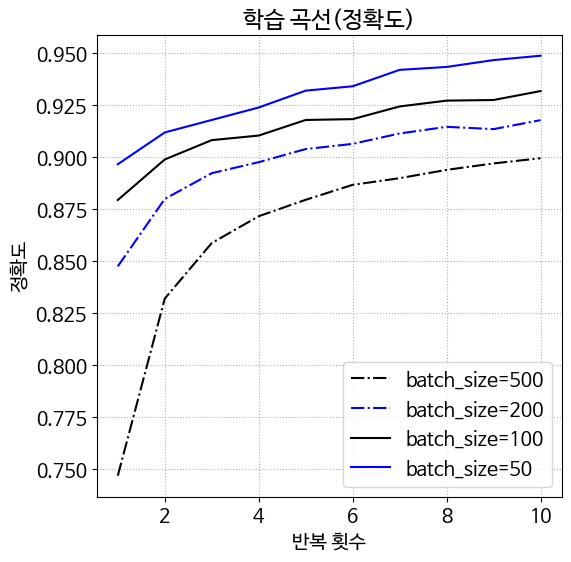

In [56]:
# 학습 곡선 출력(정확도)

plt.plot(history[:,0], history[:,4], label='batch_size=500', c='k', linestyle='-.')
plt.plot(history3[:,0], history3[:,4], label='batch_size=200', c='b', linestyle='-.')
plt.plot(history4[:,0], history4[:,4], label='batch_size=100', c='k')
plt.plot(history5[:,0], history5[:,4], label='batch_size=50', c='b')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()